In [1]:
cd /Users/duanjunyan/Desktop/CS273/final project

/Users/duanjunyan/Desktop/CS273/final project


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
np.random.seed(0)

from collections import defaultdict

np.random.seed(100)

In [3]:
# sklearn imports
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder

# other stats/math imports
import math
from scipy.stats import chi2_contingency

In [4]:
diabetes = pd.read_csv("diabetic_data.csv", delimiter=None) 
diabetes = pd.DataFrame(diabetes)

In [5]:
diabetes.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

# Data Preprocessing

### Adding in a column that counts the number of re-admissions

We noticed that in the dataset, a patient can be readmitted multiple times. Because of this, we explore the posibility of predicting repeated readmission from the data collected from the patient's first visit. To achieve this goal, we need to add a column containing the number of times a patient being re-admitted to hospital. 

We noticed that most re-admitted patients have more than one entries in the data, with one entry marked "NO" for re-admission. Since our goal here is to predict multiple readmission, we only count the number of times a patient has "<30" or ">30" in the readmitted column. For example, patient number 1152 has five entries, with four of them marked as re-admission in >30 days one one of them marked as "NO", so our count will result in 4 re-admissions. If a patient does not have any "<30" or ">30" in the readmission column, the count is 0. 


##### Add in a column that define "<30" and ">30" in the re-admitted column as "1", and "No" in the re-admitted column as "0"

In [6]:
def label_readmissionYN (row):
   if row['readmitted'] == '>30':
      return 1
   if row['readmitted']  == '<30':
      return 1
   if row['readmitted'] == 'NO':
      return 0
diabetes['readmissionYN'] = diabetes.apply (lambda row: label_readmissionYN(row), axis=1)

##### Add in a column that counts the number of re-admissions

In [7]:
diabetes_readmissionTimes = pd.DataFrame(diabetes.groupby('patient_nbr')['readmissionYN'].sum())
diabetes_readmissionTimes = diabetes_readmissionTimes.rename(columns={'readmissionYN': 'readmissionTimes'})

In [8]:
diabetes = pd.merge(diabetes, diabetes_readmissionTimes, on="patient_nbr")

##### Add in a column so that value = "1" if readmissionTimes >1, and "0" is readmissionTimes=1 

In [9]:
def label_multipleReadmission (row):
    if row['readmissionTimes'] <1:
      return 2
    if row['readmissionTimes'] >1:
      return 1
    if row['readmissionTimes'] == 1:
      return 0
diabetes['multipleReAdmYN'] = diabetes.apply (lambda row: label_multipleReadmission(row), axis=1)

In [10]:
diabetes

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,readmissionYN,readmissionTimes,multipleReAdmYN
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,NO,0,0,2
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,No,No,No,Ch,Yes,>30,1,1,0
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,Yes,NO,0,0,2
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,No,No,No,Ch,Yes,NO,0,0,2
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,No,No,No,Ch,Yes,NO,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,443842016,183087545,Caucasian,Female,[70-80),?,1,1,7,9,...,No,No,No,No,Ch,Yes,>30,1,1,0
101762,443842022,188574944,Other,Female,[40-50),?,1,1,7,14,...,No,No,No,No,Ch,Yes,>30,1,1,0
101763,443842070,140199494,Other,Female,[60-70),?,1,1,7,2,...,No,No,No,No,No,Yes,>30,1,1,0
101764,443842340,120975314,Caucasian,Female,[80-90),?,1,1,7,5,...,No,No,No,No,Ch,Yes,NO,0,0,2


### Numerical Features 
In this dataset the feature names make numerical value features self-evident. Each column with numerical features starts with "num_..."
### Categorical Features
Essentially every feature that is numerical can be considered categorical but it is not as simple as that. 
1) 2 features are patient ID features: ['encounter_id', 'patient_nbr']. It does not make sense to include them (unless we are considering a personalized Machine Learning model) <br>
2) It also does not make sense to include the target feature which is also categorical: ['readmitted', 'readmissionTimes','Multiplereadmission'] <br>
3) Certain features have numerical values that represent categories, such as: ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']. This is something we will investigate further. 


In [11]:
# list column names of features that consist of numeric values
# (in this dataset the feature names make numerical value features self-evident)
feat_num = ['num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']

# numerics = ['int16','int32','int64','float16','float32','float64']
# feat_num = list(diabetes.select_dtypes(include=numerics).columns)

# list column names of features that consist of categorical values
feat_cat = ['race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty', 'diag_1',
       'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed']

#### Count distinct values for Categorical Features

In [12]:
cat_count = defaultdict(int)
for f in feat_cat:
    cat_count[f] = len(diabetes[f].value_counts())
cat_count

defaultdict(int,
            {'race': 6,
             'gender': 3,
             'age': 10,
             'weight': 10,
             'admission_type_id': 8,
             'discharge_disposition_id': 26,
             'admission_source_id': 17,
             'time_in_hospital': 14,
             'payer_code': 18,
             'medical_specialty': 73,
             'diag_1': 717,
             'diag_2': 749,
             'diag_3': 790,
             'max_glu_serum': 4,
             'A1Cresult': 4,
             'metformin': 4,
             'repaglinide': 4,
             'nateglinide': 4,
             'chlorpropamide': 4,
             'glimepiride': 4,
             'acetohexamide': 2,
             'glipizide': 4,
             'glyburide': 4,
             'tolbutamide': 2,
             'pioglitazone': 4,
             'rosiglitazone': 4,
             'acarbose': 4,
             'miglitol': 4,
             'troglitazone': 2,
             'tolazamide': 3,
             'examide': 1,
             'citogl

In [13]:
# The features "examide" and "citoglipton" have only one value through so they can be dropped from consideration
diabetes = diabetes.drop(['examide', 'citoglipton'], axis = 1)
feat_cat = [f for f in feat_cat if f not in ('examide', 'citoglipton')]

In [14]:
# List of all medication features after removing  "examide" and "citoglipton"
medications = list(diabetes.columns)[24:45]

## Categorical features - Investigating Categories
We picked some features we thought would be relevant to look into further <br>

### Discharge Disposition ID: 
From the ID mapping that UCI ML Repository shared with us, some categories here relate to death or terminally ill facilities. Any patient that falls into these categories should possibly not be considered in our predictions because there is no way they can be readmitted. If we were to consider them, we would possibly be biasing our predictions towards "NO" readmission, which would be incorrect. Nonetheless, we might want to consider some patients who had multiple re-admissions and hence we will not completely eliminate all patients that fall in the death/hospice categories

In [15]:
## drop rows where discharge_disposition_id indicates death or hospice
# diabetes = diabetes.drop(diabetes[diabetes.discharge_disposition_id.isin([11,13,14,19,20,21])].index)
## OR, Create a Boolean for patients that died/went to hospice vs that didn't
diabetes['disposition_boolean'] = np.where((diabetes['discharge_disposition_id'].isin([11,13,14,19,20,21])),1,0)
diabetes['discharge_disposition_id'].value_counts()
feat_cat.append('disposition_boolean')

### Diagnosis Features - diag_1, diag_2, diag_3: 
- Each of the 3 features containts 700+ categories of type string <br> 
- Some of these categories are essentially numbers (floats) while others are hard strings <br>
- We convert all the strings that can be converted into floats, and coerce the others into 'nan' <br>
- Any unknowns (?) and non-float diagnisis (ex. V50) are then categorized as "Other" 

In [16]:
def diag_cat(diag_feat):
    diabetes[diag_feat] = pd.to_numeric(diabetes[diag_feat],errors= 'coerce')
    diabetes[diag_feat] = diabetes[diag_feat].fillna(0)
    
    for ind in range(len(diabetes)):
        if diabetes[diag_feat][ind] == 'nan':
            diabetes[diag_feat][ind] = "Other"
        elif round(diabetes[diag_feat][ind]) in [250,251]:
            diabetes[diag_feat][ind] = "Diabetes"
        elif diabetes[diag_feat][ind] in range(390,460) or diabetes[diag_feat][ind] == 785:
            diabetes[diag_feat][ind] = "Circulatory"
        elif diabetes[diag_feat][ind] in range(460,520) or diabetes[diag_feat][ind] == 786:
            diabetes[diag_feat][ind] = "Respiratory"
        elif diabetes[diag_feat][ind] in range(520,580) or diabetes[diag_feat][ind] == 787:
            diabetes[diag_feat][ind] = "Digestive"
        elif diabetes[diag_feat][ind] in range(800,1000):
            diabetes[diag_feat][ind] = "Injury"
        elif diabetes[diag_feat][ind] in range(710,740):
            diabetes[diag_feat][ind] = "Musculoskeletel"
        else:
            diabetes[diag_feat][ind] = "Other"

In [17]:
diag_feat = ['diag_1', 'diag_2', 'diag_3']

for f in diag_feat:
    diag_cat(f)

/var/folders/f3/h1lwr6ps6f78b37s9ljgnp5w0000gn/T/ipykernel_35195/2306081007.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diabetes[diag_feat][ind] = "Diabetes"
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/var/folders/f3/h1lwr6ps6f78b37s9ljgnp5w0000gn/T/ipykernel_35195/2306081007.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

In [18]:
diabetes['diag_1'].value_counts()

Circulatory        30437
Other              26728
Respiratory        14423
Digestive           9475
Diabetes            8772
Injury              6974
Musculoskeletel     4957
Name: diag_1, dtype: int64

### Gender, Age, Admissions Type, and Admissions Source
Age is a categorical feature, which we can consider turning into a numerical value by finding the mean of each range. This converts the feature into a numeric (but we shall not consider this as part of PCA because we understand that Age is an important factor in understanding readmissions and hence should not be put under the dimensionality reduction bucket. <br>

In [19]:
# Gender
diabetes = diabetes[diabetes['gender'] != 'Unknown/Invalid']
diabetes['gender'].value_counts()

# Age
age_dict = {'[0-10)' : 5,
'[10-20)' : 15,
'[20-30)' : 25, 
'[30-40)' : 35, 
'[40-50)' : 45, 
'[50-60)' : 55,
'[60-70)' : 65, 
'[70-80)' : 75,
'[80-90)' : 85,
'[90-100)' : 95}

diabetes['age'] = diabetes['age'].apply(lambda x : age_dict[x])

# Admissions
diabetes['admission_type_id'] = \
diabetes['admission_type_id'].apply(lambda x : 'Unavailable' if int(x) in [5, 6, 8]
                                                            else 'Elective')



diabetes['admission_source_id'] = \
diabetes['admission_source_id'].apply(lambda x : 'Referral' if int(x) in [5, 6, 8]
                                            else ('Emergency Room' if int(x) in [7]
                                            else 'Other'))


## Investigating Multiple Readmissions
Some patients show up more than once in our dataset. It is a very small subset of the larger dataset so we first start with considering only once patient visit - which, in our case, would be the very last occurance for that patient. 

In [20]:
## Count the number of multiple readmissions for a single patient
# data = diabetes[diabetes['readmitted'] != 'NO']
# unique_patients = data[['patient_nbr']]
# unique_patients = unique_patients['patient_nbr'].value_counts().to_frame()
# unique_patients["index"] = unique_patients.index
# len(unique_patients[unique_patients["patient_nbr"] > 1])

In [21]:
diabetes = diabetes.drop_duplicates(subset= 'patient_nbr', keep='first')
diabetes.shape

(71515, 52)

## Investigating Missing Values (?) 
Features with missing values: <br>
**Weight** - replaced it with the mode <br>
Another way to impute the missing weights would have been to find the closest neighbors. For us, a "neighbor" would be another patient with similar comorbidities. These comorbidities could be respresented in multiple ways such as (1) diagonasis (dia_1, 2, and 3) 2) number of meds, <br>
**Race** - replaced it with "UNK" <br>
**Medical Speciality** - replaced it with "UNK" <br>
**Payer Code** - replaced it with "UNK" <br>

(**diag_1, diag_2, diag_3** also had missing values but those have already been handled above)

In [22]:
for col in diabetes.columns:
    if diabetes[col].dtype == object:
        count = diabetes[col][diabetes[col] == '?'].count()
        if count > 0:
            print(col, count)

race 1946
weight 68662
payer_code 31042
medical_specialty 34475


In [23]:
## Weights: Because most weights are missing, we replace the ? with most common weight
diabetes['weight'] = np.where((diabetes['weight'] == "?"),"[75-100)",diabetes['weight'])
## Race: replace with UNK
diabetes['race'] = np.where((diabetes['race'] == "?"),"UNK",diabetes['race'])
## Medical Speciality: replace with UNK
diabetes['medical_specialty'] = np.where((diabetes['medical_specialty'] == "?"),"UNK",diabetes['medical_specialty'])
## payer_code: replace with UNK
diabetes['payer_code'] = np.where((diabetes['race'] == "?"),"UNK",diabetes['payer_code'])

In [24]:
# drop payer_code because it doesn't seem to explain very much 
# drop medical speciality because it has too many missing values
feat_cat = [f for f in feat_cat if f not in ('payer_code', 'medical speciality')]

### Data after Preprocessing

In [25]:
X = diabetes[feat_num + feat_cat]
y = diabetes['multipleReAdmYN']

# Train Test Split

In [26]:
Xtr, Xte, Ytr, Yte = train_test_split(X, y, test_size=0.3, random_state=1)

# Feature Selection

## Feature Scaling - should we scale before train_test_split???
As a first step, we will only normalize the numerical features. Later on, we will consider normalizing all features (for instance, if we use a multivariate feature selection model such as Lasso)

In [27]:
# convert numerical features from strings to floats
for f in feat_num:
    diabetes[f] = pd.to_numeric(diabetes[f],errors= 'coerce')
    
scaler = StandardScaler()

# scaling training data
Xtr_num = Xtr[feat_num]
scaler.fit(Xtr_num)
Xtr_numSc = scaler.fit_transform(Xtr_num)

# transforming test data based on the fit from training data
Xte_num = Xte[feat_num]
Xte_numSc = scaler.transform(Xte_num)

In [28]:
# construct the new training data with scaled features
Xtr_cat = np.array(Xtr[feat_cat])
Xtr = np.concatenate([Xtr_numSc, Xtr_cat], axis = 1)
Xtr = pd.DataFrame(Xtr)
Xtr.columns = [feat_num + feat_cat]

# construct the new test data with the scaled features
Xte_cat = np.array(Xte[feat_cat])
Xte = np.concatenate([Xte_numSc, Xte_cat], axis = 1)
Xte = pd.DataFrame(Xte)
Xte.columns = [feat_num + feat_cat]

## Feature Selection - Numerical Features  (Principal Component Analysis)

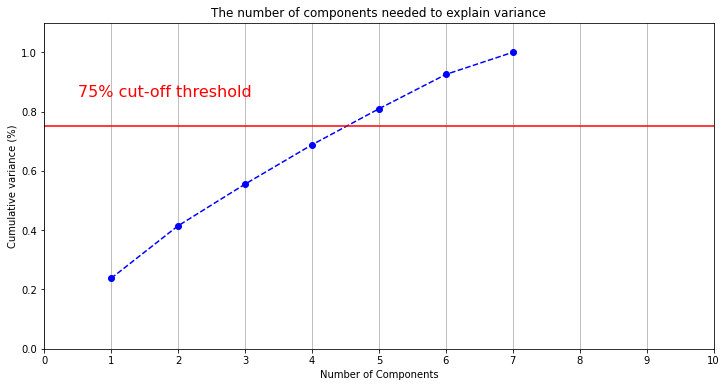

In [29]:
pca = PCA().fit(Xtr_numSc)

plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 8, step=1)
Var = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, Var, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 11, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.75, color='r', linestyle='-')
plt.text(0.5, 0.85, '75% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [30]:
# compoonents that explain 75% of the variances 
pca = PCA(n_components=5)

# fit PCA on the training data
XtrPCA_num = pca.fit_transform(Xtr_numSc)
XtrPCA_num = pd.DataFrame(XtrPCA_num)
XtrPCA_num.columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5']
# XtrPCA_num

# transform test data based on the PCA fit from training
XtePCA_num = pca.transform(Xte_numSc)
XtePCA_num = pd.DataFrame(XtePCA_num)
XtePCA_num.columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5']
# XtePCA_num

## Feature Selection - Categorical Features 

### Step 1: Investigate the value count for each medication
If we realize that hardly anyone was prescribed that medication, it is perhaps a good idea to not consider it in our analysis <br>

We run the risk of excluding patients that were specifically chosen for rare medications which hardly prescribed (and hence eliminated from our feature set). 

In [31]:
threshold = 70000

med_count = defaultdict(list)

for med in medications:
    # count the number of Nos, Ups, Downs, and Steadys for each medication
    med_count[med].append(list(diabetes[med].value_counts()))
    
    # if the number of Nos is > 100K, disregard the medication for now 
    if med_count[med][0][0] > threshold:
        med_count.pop(med)
med_count
meds_new = list(med_count)
# meds_new

### Step 2: Chi Square

Lets first try to find any relations between the medication features <br>

#### Approach 1: Cross Tabulation
$D$ = Number of Medication features <br>
Null Hypothesis ($H_O$): Features are independent - there is no relationship between features $x^i$ and $x^j$ where $i, j$ $\in$ $(1,...,D)$ <br>
Alternate Hypothesis ($H_1$): Features are independent - there is a relationship between features <br>
Let's consider p-value for $H_O$ = .05 $\Rightarrow$ if p-value for a relation is < .05, then we fail to reject $H_O$ <br>

As we can see, none of our p-values are greater than the significance level, so we fail to reject the null hypothesis for any of them. Thus, we continue to consider all the medication features to be independent from each other. 

In [32]:
chi_p = [[0]*7 for _ in range(7)]
for med1 in meds_new:
    for med2 in meds_new:
        chi_p[meds_new.index(med1)][meds_new.index(med2)] = chi2_contingency(pd.crosstab(diabetes[med1], diabetes[med2]))[1]
chi_p = np.array(chi_p)   
# chi_p       

#### Approach 2: Ordinal / One Hot Encoding
come back to it

In [33]:
# # encode some catagorical features in the input data
# def prepare_inputs(Xtr, Xte):
#     ordEnc = OrdinalEncoder()
#     ordEnc.fit(Xte)
#     XtrEnc = ordEnc.transform(Xtr)
#     XteEnc = ordEnc.transform(Xte)
#     return XtrEnc, XteEnc
 
# # encode the target feature (categorical)
# def prepare_targets(Ytr, Yte):
#     labEnc = LabelEncoder()
#     labEnc.fit(Ytr)
#     YtrEnc = labEnc.transform(Ytr)
#     YteEnc = le.transform(Yte)
#     return YtrEnc, YteEnc
 
# # feature selection
# ## concern - this can only work if we only have categorical features 
# def select_features(Xtr, Xte, Ytr):
#     featSel = SelectKBest(score_func=chi2, k='all')
#     featSel.fit(Xtr, Ytr)
#     XtrSel = featSel.transform(Xtr)
#     XteSel = featSel.transform(Xte)
#     return XtrSel, XteSel, featSel

### Final set of categorical features

In [34]:
# disposition id replaced by the booleans
feat_catN = ['gender', 'age', 'weight', 'admission_type_id', 'admission_source_id', 'disposition_boolean',
           'time_in_hospital'] + diag_feat + meds_new + ['change', 'diabetesMed']

In [35]:
Xtr_cat = Xtr[feat_catN]
Xte_cat = Xte[feat_catN]

## Final Train and Test Data with Selected Catagorical Features and PCAs 

In [36]:
features = list(XtrPCA_num.columns) + feat_catN

# final training data 
Xtr = np.concatenate([np.array(XtrPCA_num), np.array(Xtr_cat)], axis = 1)
Xtr = pd.DataFrame(Xtr)
Xtr.columns = features
# Xtr

# final test data
Xte = np.concatenate([np.array(XtePCA_num), np.array(Xte_cat)], axis = 1)
Xte = pd.DataFrame(Xte)
Xte.columns = features
# Xte

## One Hot Encode the Final Set of Categorical Features (If needed)

In [37]:
# Features to One Hot Encode
feat_OHE = ['gender', 'weight', 'admission_type_id', 'admission_source_id', 'disposition_boolean'] + \
            diag_feat + meds_new + ['change', 'diabetesMed']
Xtr_OHE = Xtr[feat_OHE]


# fit OHE on to the training data
OHE = OneHotEncoder(categories='auto')
Xtr_OHE = OHE.fit_transform(Xtr_OHE).toarray()
Xtr_OHE = pd.DataFrame(Xtr_OHE)

# transform OHE fit into test data
Xte_OHE = Xte[feat_OHE]
Xte_OHE = OHE.transform(Xte_OHE).toarray()
Xte_OHE = pd.DataFrame(Xte_OHE)

In [38]:
# extract column names for OHE categories
OHE_cols = []
OHE_cols_ = OHE.categories_
for col, vals in zip(Xtr_OHE.columns, OHE_cols_):
    for val in vals:
        name = str(col) + '_' + str(val)
        OHE_cols.append(name)

Xtr_OHE.columns = OHE_cols
Xte_OHE.columns = OHE_cols

In [39]:
Xtr = pd.concat([XtrPCA_num, Xtr_OHE], axis = 1)
Xte = pd.concat([XtePCA_num, Xte_OHE], axis = 1)

In [40]:
xtrain, xtest, ytrain, ytest = Xtr.copy(), Xte.copy(), Ytr.copy(), Yte.copy()
ytrain = Ytr.reset_index(drop = True)
ytest = Yte.reset_index(drop = True)
xtrain = xtrain[ytrain!=2].reset_index(drop = True)
ytrain = ytrain[ytrain!=2].reset_index(drop = True)
xtest = xtest[ytest!=2].reset_index(drop = True)
ytest = ytest[ytest!=2].reset_index(drop = True)
xtrainOrig, ytrainOrig = xtrain.copy(), ytrain.copy()

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
smote = SMOTE(random_state = 0)
xtrain, ytrain = smote.fit_resample(xtrain, ytrain)

In [47]:
xtrain.shape

(27660, 76)

# Train Models 

## Support vector machines

In [42]:
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn import datasets
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

### Linear kernel

In [43]:
svm_lknl = svm.SVC(cache_size = 1000, kernel='linear')
svm_lknl_scores = cross_val_score(svm_lknl, xtrain, ytrain, cv=5)

In [44]:
np.mean(svm_lknl_scores)

0.5671005061460592

In [69]:
np.var(svm_lknl_scores)

0.00013800466254576635

### Radial Basis Function Kernel

In [48]:
svm_rbfknl = svm.SVC(cache_size = 1000, kernel='rbf')
svm_rbfknl_scores = cross_val_score(svm_rbfknl, xtrain, ytrain, cv=5)
svm_rbfknl_scores

array([0.5867679 , 0.5808026 , 0.65563991, 0.68004338, 0.69360087])

In [49]:
np.mean(svm_rbfknl_scores)

0.6393709327548807

In [73]:
np.var(svm_rbfknl_scores)

0.002211428517652373

### Polynomial Kernel

In [50]:
svm_polyknl = svm.SVC(cache_size = 1000, kernel='poly')
svm_polyknl_scores = cross_val_score(svm_polyknl, xtrain, ytrain, cv=5)
svm_polyknl_scores

array([0.58767173, 0.58279103, 0.64407086, 0.66883586, 0.68438178])

In [51]:
np.mean(svm_polyknl_scores)

0.6335502530730297

In [74]:
np.var(svm_polyknl_scores)

0.0017241877796128915

### Sigmoid Kernel

In [52]:
svm_sigknl = svm.SVC(cache_size = 1000, kernel='sigmoid')
svm_sigknl_scores = cross_val_score(svm_sigknl, xtrain, ytrain, cv=5)
svm_sigknl_scores

array([0.48933478, 0.48734635, 0.48101952, 0.4681851 , 0.4763196 ])

In [53]:
np.mean(svm_sigknl_scores)

0.48044107013738246

In [75]:
np.var(svm_sigknl_scores)

5.886215689011657e-05

## Logistic regression

In [54]:
from sklearn.linear_model import LogisticRegression

### Without regulariztion

In [55]:
logReg_Bal_none = LogisticRegression(fit_intercept = True, class_weight= 'balanced', 
                                   penalty = 'none', solver = "saga", max_iter = 500)
logReg_Bal_none_scores = cross_val_score(logReg_Bal_none, xtrain, ytrain, cv=5)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was

In [56]:
np.mean(logReg_Bal_none_scores)

0.5647143890093999

In [70]:
np.var(logReg_Bal_none_scores)

0.00016776119902399156

### With lasso

In [57]:
logReg_Bal_L1 = LogisticRegression(fit_intercept = True, class_weight= 'balanced', 
                                   penalty = 'l1', solver='saga', max_iter = 500)
logReg_Bal_L1_scores = cross_val_score(logReg_Bal_L1, xtrain, ytrain, cv=5)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was

In [58]:
np.mean(logReg_Bal_L1_scores)

0.5653289949385394

In [71]:
np.var(logReg_Bal_L1_scores)

0.0001479670767176467

### With ridge

In [59]:
logReg_Bal_L2 = LogisticRegression(fit_intercept = True, class_weight= 'balanced', 
                                   penalty = 'l2', solver='saga', max_iter = 500)
logReg_Bal_L2_scores = cross_val_score(logReg_Bal_L2, xtrain, ytrain, cv=5)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was

In [60]:
np.mean(logReg_Bal_L2_scores)

0.565003615328995

In [72]:
np.var(logReg_Bal_L2_scores)

0.0001590378780868188

# Train predictor using SVM with RBF kernel

In [61]:
svm_rbfknl.fit(xtrain, ytrain)

SVC(cache_size=1000)

# test

In [62]:
svm_rbfknl_Yhat = svm_rbfknl.predict(xtest)

In [63]:
sum(svm_rbfknl_Yhat==ytest)/len(ytest)

0.5595154903331004

In [64]:
from sklearn.metrics import confusion_matrix

In [65]:
tn, fp, fn, tp = confusion_matrix(ytest, svm_rbfknl_Yhat).ravel()

In [66]:
(tn, fp, fn, tp)

(3363, 2549, 1233, 1441)

In [67]:
fpr, tpr, threshold = metrics.roc_curve(ytest, svm_rbfknl_Yhat)
roc_auc = metrics.auc(fpr, tpr)

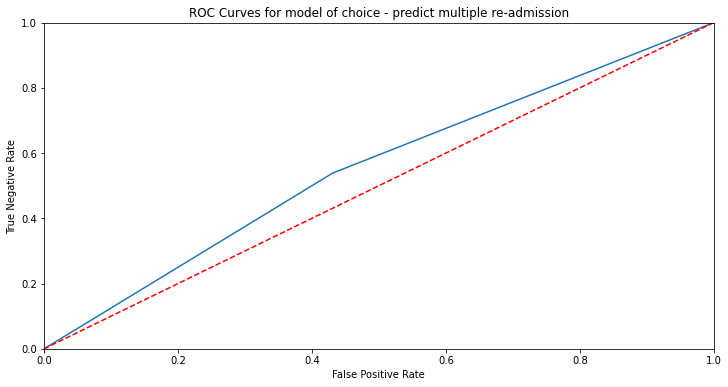

In [68]:
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], 'r--')
plt.title ('ROC Curves for model of choice - predict multiple re-admission')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Negative Rate')
plt.xlabel('False Positive Rate')
plt.show()